## Setup


In [2]:
import json
import wandb
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import Dataset, DatasetDict, load_from_disk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

In [3]:
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})

In [4]:
seed = 42
data_path = "./data/irony_processed_data"
model_ckpt = "UBC-NLP/MARBERT"
model_name = "marbert-finetuned-wanlp_sarcasm"
model_path = f"./models/{model_name}"

## Data Preprocessing


In [5]:
dataset = load_from_disk(data_path)
dataset

Dataset({
    features: ['labels', 'text'],
    num_rows: 15548
})

In [6]:
train_data, valid_data = train_test_split(
    dataset.to_pandas(),
    random_state=seed,
    train_size=0.6,
    stratify=dataset[:]["labels"],
)

valid_data, test_data = train_test_split(
    valid_data,
    random_state=seed,
    train_size=0.5,
    stratify=valid_data["labels"],
)

In [7]:
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [8]:
train_data.labels.value_counts(normalize=True)

0    0.807783
1    0.192217
Name: labels, dtype: float64

In [9]:
valid_data.labels.value_counts(normalize=True)

0    0.807717
1    0.192283
Name: labels, dtype: float64

In [10]:
test_data.labels.value_counts(normalize=True)

0    0.807717
1    0.192283
Name: labels, dtype: float64

In [11]:
dataset = DatasetDict({})
dataset["train"] = Dataset.from_pandas(train_data)
dataset["valid"] = Dataset.from_pandas(valid_data)
dataset["test"] = Dataset.from_pandas(test_data)
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 9328
    })
    valid: Dataset({
        features: ['labels', 'text'],
        num_rows: 3110
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 3110
    })
})

In [12]:
label_names = ["Non-Sarcasm", "Sarcasm"]

In [13]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

## Tokenization


In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
def tokenize_ds(batch):
    return tokenizer(batch["text"], truncation=True)

In [16]:
encoded_data = dataset.map(tokenize_ds, batched=True, remove_columns=["text"])

Map:   0%|          | 0/9328 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3110 [00:00<?, ? examples/s]

Map:   0%|          | 0/3110 [00:00<?, ? examples/s]

In [17]:
encoded_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9328
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3110
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3110
    })
})

## Modeling


In [18]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average="binary")
    prec = precision_score(labels, pred, average="binary")
    rec = recall_score(labels, pred, average="binary")
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Training


In [21]:
with open("./data/access_tokens.json") as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
wandb.init(project="irony-detection", name="stratified-weighted")

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


In [23]:
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    logging_steps=50,
    learning_rate=2e-5,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
)

In [24]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [25]:
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (-pred.sum(dim=1))
        return self.scale * nce.mean()


class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        mae = 1.0 - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()


class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

In [26]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")  # [batch_size, num_labels]
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = NCEandMAE(alpha=1.0, beta=1.0, num_classes=len(label_names))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [27]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.383100,0.384712,0.807717,0.000000,0.000000,0.000000
2,0.391400,0.384638,0.807717,0.000000,0.000000,0.000000
3,0.380100,0.384624,0.807717,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=876, training_loss=0.40632032912615773, metrics={'train_runtime': 333.0412, 'train_samples_per_second': 84.026, 'train_steps_per_second': 2.63, 'total_flos': 720554291764800.0, 'train_loss': 0.40632032912615773, 'epoch': 3.0})

In [29]:
trainer.evaluate(encoded_data["test"], metric_key_prefix="test")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 0.3846244812011719,
 'test_Accuracy': 0.8077170418006431,
 'test_Precision': 0.0,
 'test_Recall': 0.0,
 'test_F1': 0.0,
 'test_runtime': 9.2162,
 'test_samples_per_second': 337.449,
 'test_steps_per_second': 10.633,
 'epoch': 3.0}

In [30]:
outs = trainer.predict(encoded_data["test"])
preds = np.argmax(outs[0], axis=-1)
labels = outs[1]

print(classification_report(labels, preds, target_names=label_names))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Non-Sarcasm       0.81      1.00      0.89      2512
     Sarcasm       0.00      0.00      0.00       598

    accuracy                           0.81      3110
   macro avg       0.40      0.50      0.45      3110
weighted avg       0.65      0.81      0.72      3110



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


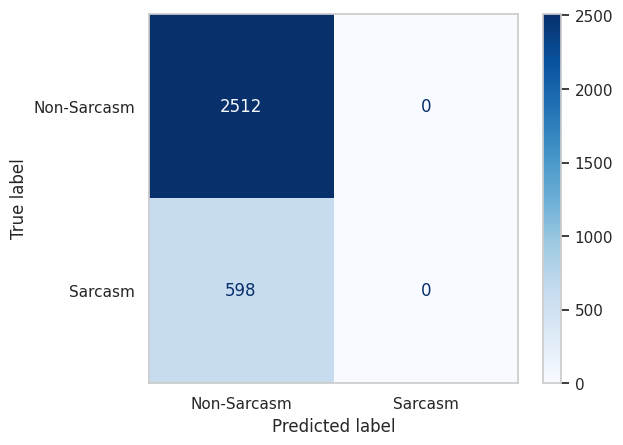

In [31]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues")
plt.show()

In [32]:
wandb.finish()

eval/Accuracy,▁▁▁
eval/F1,▁▁▁
eval/Precision,▁▁▁
eval/Recall,▁▁▁
eval/loss,█▂▁
eval/runtime,█▃▁
eval/samples_per_second,▁▆█
eval/steps_per_second,▁▆█
test/Accuracy,▁
test/F1,▁
test/Precision,▁
